The goal of this notebook is to check the correctness of the QQt analytical solution step by step against an example done computationally

In [1]:
import gooseberry as gs 

import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from matplotlib.patches import Ellipse
import numpy as np 

import jax 
import jax.numpy as jnp
from functools import partial 

from dynamics import QQT 
from dynamics import QQT_balanced
from tools import BlindColours, zero_balanced_weights

In [3]:
"""
randomly initialised balanced weights of dimensions in_dim, 
hidden_dim, out_dim and balance coefficient c
""" 


def balanced_weights(in_dim, hidden_dim, out_dim, c):

    #random number bigger than c:
    a = np.random.exponential(scale = 5) + c 
    b = np.sqrt(a*a - c)

    #TODO: not sure which dimension, doesnt work for hidden_dim > min(out_dim, in_dim)
    S_1 = a * np.eye(max(hidden_dim, in_dim))[:hidden_dim, :in_dim]
    S_2 = b * np.eye(max(out_dim, hidden_dim))[:out_dim, :hidden_dim] 

    random_matrix_one = np.random.rand(hidden_dim, hidden_dim)
    random_matrix_two = np.random.rand(in_dim, in_dim)
    random_matrix_three = np.random.rand(out_dim, out_dim)

    q_one, _ = np.linalg.qr(random_matrix_one)
    q_two, _ = np.linalg.qr(random_matrix_two)
    q_three, _ = np.linalg.qr(random_matrix_three)

    U_1 = q_one 
    V_2 = q_one 
    V_1 = q_two
    U_2 = q_three

    W1 = U_1 @ S_1 @ (V_1.T)
    W2 = U_2 @ S_2 @ (V_2.T)

    return W1, W2 



In [3]:
def check_balance(w1, w2):
    return w1 @ w1.T - w2.T @ w2 

In [4]:
w1, w2 = balanced_weights(4, 4, 4, 2)

check_balance(w1, w2)

array([[ 2.00000000e+00, -1.02011512e-15,  5.98910299e-16,
        -6.83984345e-16],
       [-1.02011512e-15,  2.00000000e+00, -3.69134453e-16,
        -3.76780704e-16],
       [ 5.98910299e-16, -3.69134453e-16,  2.00000000e+00,
        -2.03513659e-15],
       [-6.83984345e-16, -3.76780704e-16, -2.03513659e-15,
         2.00000000e+00]])

AssertionError: X not whitened

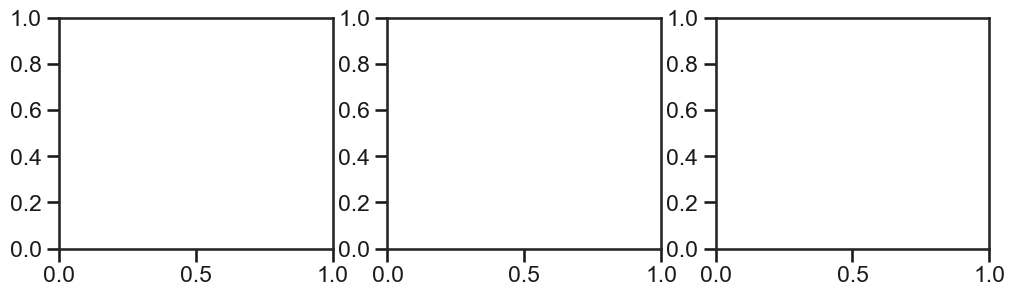

In [43]:
np.random.seed(1)

in_dim = 2
hidden_dim = 10
out_dim = 2

batch_size = 1
learning_rate = 0.1
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])
    
    X, Y = train(None)
    # print(X, Y)
    # analytical = analytical_euler(init_w1, init_w2, X, Y,batch_size)
    analytical = QQT_balanced(init_w1, init_w2, X.T, Y.T, True)
    analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")

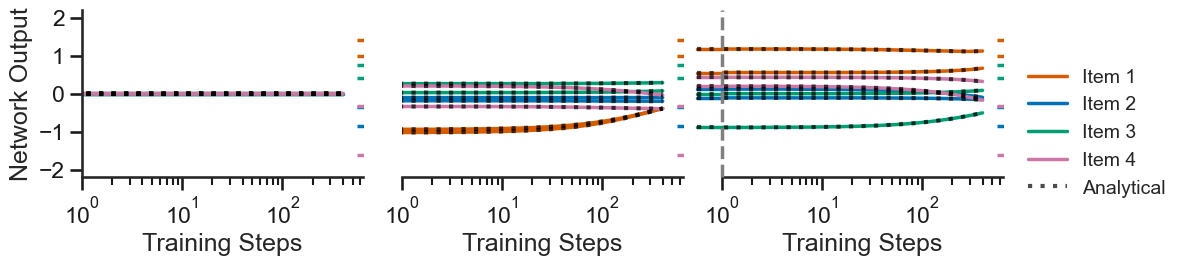

In [69]:
np.random.seed(1)

in_dim = 5
hidden_dim = 10
out_dim = 2

batch_size = 10
learning_rate = 0.001
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])
    
    X, Y = train(None)
    # analytical = analytical_euler(init_w1, init_w2, X, Y)
    analytical = QQT_balanced(init_w1, init_w2, X.T, Y.T, 0, True)
    analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")

In [14]:
np.asarray(ws[:3])

array([[[[ 1.2501757e-04,  3.8394789e-04, -1.0329639e-04,
           8.0817757e-05, -3.6776072e-04],
         [-1.5681733e-03, -3.2734799e-06,  1.9824882e-04,
           3.5485064e-04, -4.4906815e-04]]],


       [[[-5.0692339e-05,  3.4286667e-04, -8.3742125e-05,
           1.3481437e-04, -3.9387334e-04],
         [-1.6428637e-03, -9.3429764e-05,  2.4288138e-04,
           4.3071841e-04, -4.4630369e-04]]],


       [[[-2.3573849e-04,  2.9371073e-04, -5.8311067e-05,
           2.0159049e-04, -4.2509986e-04],
         [-1.7354252e-03, -1.9344052e-04,  2.9055378e-04,
           5.1964796e-04, -4.4755783e-04]]]], dtype=float32)

In [70]:
def analytical_euler(init_w1, init_w2, X, Y, batch_size = batch_size, learning_rate = learning_rate, training_steps = training_steps):

    # print(X)
    # print(Y)
    c = 0
    Q0 = np.vstack([init_w1.T, init_w2])

    QQt0 = Q0 @ Q0.T

    required_shape = (init_w2@init_w1).shape
    

    # print(X.T.shape)
    # print(Y.shape)
    # sigma_xy= (1. / batch_size) * X @ Y.T
    sigma_xy = Y.T @ X
    # print(sigma_xy)

    F = np.vstack([
        np.hstack([c / 2 * np.eye(sigma_xy.shape[1]), sigma_xy.T]),
        np.hstack([sigma_xy, c / 2 * np.eye(sigma_xy.shape[0])])
    ]) 

    QQts = [QQt0]
    w2w1s = [[QQt0[-required_shape[0]:, :required_shape[1]]]]

    for i in range(training_steps):
        curr = QQts[-1]
        # print(curr)
        # print(F)
        derivative = F @ curr + curr @ F - curr @ curr.T
        next = curr + learning_rate * derivative
        QQts.append(next)
        # print(next.shape)
        w2w1s.append(np.array([next[-required_shape[0]:, :required_shape[1]]]))

    return np.array(w2w1s)


In [71]:
task = gs.tasks.FullBatchLearning(train)
optimiser = gs.GradientDescent(learning_rate)
loss = gs.MeanSquaredError()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)

mlp = gs.Network([
    gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
    gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
])

trainer = gs.Trainer(task, mlp, loss, optimiser)
state, params = gs.assemble(1)

losses = []
ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]

for training_step in range(training_steps):
    state, params, loss = trainer(state, params)
    losses.append(loss)
    ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])

X, Y = train(None)
analytical = analytical_euler(init_w1, init_w2, X, Y)

In [72]:
ws

[Array([[[-0.08532526,  0.00897011,  0.16370206, -0.00557357,
           0.01010345],
         [ 0.02284438, -0.39377412,  0.3931189 ,  0.05205997,
           0.38978496]]], dtype=float32),
 Array([[[-0.08545981,  0.00885948,  0.16369802, -0.00547061,
           0.01010312],
         [ 0.02265137, -0.39374012,  0.3928716 ,  0.05231794,
           0.3894218 ]]], dtype=float32),
 Array([[[-0.08559444,  0.00874873,  0.16369425, -0.00536761,
           0.0101029 ],
         [ 0.02245858, -0.3937064 ,  0.3926248 ,  0.05257559,
           0.3890594 ]]], dtype=float32),
 Array([[[-0.08572916,  0.00863785,  0.16369069, -0.00526458,
           0.01010279],
         [ 0.02226599, -0.3936729 ,  0.39237872,  0.05283291,
           0.38869765]]], dtype=float32),
 Array([[[-0.08586396,  0.00852684,  0.1636874 , -0.00516151,
           0.01010279],
         [ 0.02207362, -0.39363974,  0.3921332 ,  0.0530899 ,
           0.38833672]]], dtype=float32),
 Array([[[-0.08599886,  0.00841571,  0.16368434, -

In [73]:
analytical

array([[[[-8.53252532e-02,  8.97010745e-03,  1.63702048e-01,
          -5.57356583e-03,  1.01034542e-02],
         [ 2.28443803e-02, -3.93774104e-01,  3.93118885e-01,
           5.20599741e-02,  3.89784937e-01]]],


       [[[-8.69010131e-02,  7.36855631e-03,  1.64684313e-01,
          -4.49220900e-03,  1.06487821e-02],
         [ 2.10791731e-02, -3.98226290e-01,  3.95658391e-01,
           5.52681358e-02,  3.90921239e-01]]],


       [[[-8.84992826e-02,  5.73320743e-03,  1.65702747e-01,
          -3.39207873e-03,  1.12110303e-02],
         [ 1.92844546e-02, -4.02725968e-01,  3.98227776e-01,
           5.85123011e-02,  3.92068086e-01]]],


       ...,


       [[[-6.70287826e+00, -4.41487858e+00,  4.11843575e-01,
           4.47725938e+00, -3.78795099e-01],
         [-2.92492032e+00, -4.08722214e+00,  1.16575055e+00,
           3.57212407e+00,  2.57391032e-01]]],


       [[[-6.70989718e+00, -4.41426443e+00,  4.07513561e-01,
           4.47791455e+00, -3.80212334e-01],
         [-2.920

In [74]:
diff = [analytical[i] - ws[i] for i in range(len(ws))]

In [42]:
diff

[Array([[[-1.3969839e-09,  0.0000000e+00,  7.4505806e-09,  0.0000000e+00,
           2.9802322e-08],
         [ 0.0000000e+00, -3.7252903e-09, -2.9802322e-08, -1.4901161e-08,
           7.4505806e-09]]], dtype=float32),
 Array([[[-0.00337344, -0.0021193 ,  0.00091276,  0.00257652,
          -0.00102177],
         [-0.00056885, -0.00206565,  0.00220588,  0.00240722,
          -0.00074396]]], dtype=float32),
 Array([[[-0.00677126, -0.00426337,  0.00181326,  0.00516611,
          -0.00208008],
         [-0.00113809, -0.00411847,  0.00438526,  0.0047932 ,
          -0.00150942]]], dtype=float32),
 Array([[[-0.01019502, -0.0064334 ,  0.00270184,  0.00777006,
          -0.00317496],
         [-0.00170875, -0.00615944,  0.0065386 ,  0.00715895,
          -0.00229637]]], dtype=float32),
 Array([[[-0.01364628, -0.00863045,  0.00357884,  0.01038958,
          -0.00430638],
         [-0.00228184, -0.00818954,  0.00866634,  0.00950553,
          -0.00310484]]], dtype=float32),
 Array([[[-0.0171266

In [21]:
import numpy as np

# Create a sample matrix
matrix = np.array([
    [1, 2, 3, 4, 5, 6],
    [7, 8, 9, 10, 11, 12],
    [13, 14, 15, 16, 17, 18],
    [19, 20, 21, 22, 23, 24]
])

# Get the last two rows and first five columns
result = matrix[-2:, :5]

print("Original matrix:")
print(matrix)

print("\nResult:")
print(result)

Original matrix:
[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]
 [13 14 15 16 17 18]
 [19 20 21 22 23 24]]

Result:
[[13 14 15 16 17]
 [19 20 21 22 23]]


(2, 2)
(2, 2)
(2, 2)


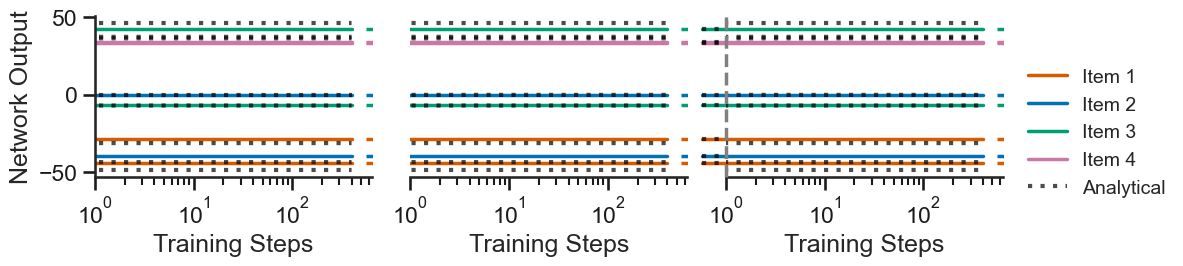

In [68]:
np.random.seed(1)

# in_dim = 5
# hidden_dim = 10
# out_dim = 2

in_dim = 2
hidden_dim = 2
out_dim = 2

batch_size = 10
learning_rate = 0.1
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()
c = 10

init_w1, init_w2 = simple_balanced_weights(in_dim, hidden_dim, out_dim, c)
train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    # init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    init_w1, init_w2 = simple_balanced_weights(in_dim, hidden_dim, out_dim, c=c)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])
    
    X, Y = train(None)
    analytical = QQT_balanced(init_w1, init_w2, X.T, Y.T, c, True)
    # analytical = QQT(init_w1, init_w2, X.T, Y.T, True)

    desired_shape = (init_w2@init_w1).shape

    analytical = np.asarray([analytical.forward(learning_rate)[-desired_shape[0]:, :desired_shape[1]] for _ in range(training_steps)])
    print(analytical[0].shape)
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    # axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        # axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")

In [6]:
balanced_weights(5, 10, 2, 0.1)

(array([[-1.95549435,  0.68114377,  4.37622359,  3.64654932, -1.09446242],
        [-2.6122755 ,  0.08030441,  5.25007901, -3.14442553,  2.03494266],
        [ 0.76645518,  0.46261049,  0.83727096,  5.01803566, -0.47762219],
        [-2.38403089,  3.7942731 , -0.08266816,  0.84636723,  2.81866599],
        [ 4.93763106,  3.84290068,  0.7602099 , -2.61251565, -0.64235016],
        [ 2.55329159, -0.72090457,  3.5044797 ,  2.26057385,  0.27619453],
        [ 1.9480303 ,  1.28333276,  3.42284135, -2.43057854, -1.40878072],
        [ 1.81589253,  4.67231425, -0.81689778,  2.3691597 , -0.3117877 ],
        [ 4.33694136, -4.07454656,  0.80010331,  1.07708351,  3.87634581],
        [-0.11839891,  1.81272127, -0.65476447,  0.18957582,  6.52879727]]),
 array([[ 3.35295303,  5.01378391, -0.14168329,  2.34062187,  2.68103244,
          1.45995706,  3.59179753,  1.45523272, -2.68042058,  0.4818497 ],
        [ 1.30302421, -1.28450172,  3.33221104,  1.39840201,  1.23844489,
          3.26080503, -0.

In [10]:
zero_balanced_weights(5, 10, 2, 0.35)

(array([[ 0.41803927,  0.01610867, -0.1954986 ,  0.01504016, -0.32448512],
        [ 0.30612651, -0.17298806, -0.02419603, -0.02086268,  0.05447954],
        [-0.13386847,  0.30960571, -0.14004377,  0.0494825 , -0.39365273],
        [-0.47971254,  0.18757952,  0.09167406,  0.01828843,  0.04662027],
        [ 0.23882407, -0.26038283,  0.06187428, -0.03791284,  0.24076962],
        [-0.24419044,  0.09690265,  0.0457523 ,  0.00955408,  0.02148966],
        [ 0.41035772,  0.23884006, -0.33549342,  0.05323742, -0.67107243],
        [ 0.2299501 , -0.02655629, -0.08473565,  0.00216343, -0.12250339],
        [-0.24222715,  0.09768579,  0.04437867,  0.00974676,  0.01884738],
        [ 0.05548929, -0.21615964,  0.11459233, -0.03566137,  0.3020024 ]]),
 array([[-0.40199056, -0.34983421,  0.22320061,  0.52314316, -0.31056731,
          0.26672377, -0.32766581, -0.2317521 ,  0.26504819, -0.11887763],
        [-0.39642959,  0.07240893, -0.49089836,  0.05043288,  0.30268783,
          0.0228885 , -0.

In [14]:
def simple_balanced_weights(in_dim, hidden_dim, out_dim, c):

    a = c + 1
    b = (2 * c + 1) ** 0.5
    w1 = a * np.eye(in_dim)

    w2 = b * np.eye(out_dim)

    return w1, w2

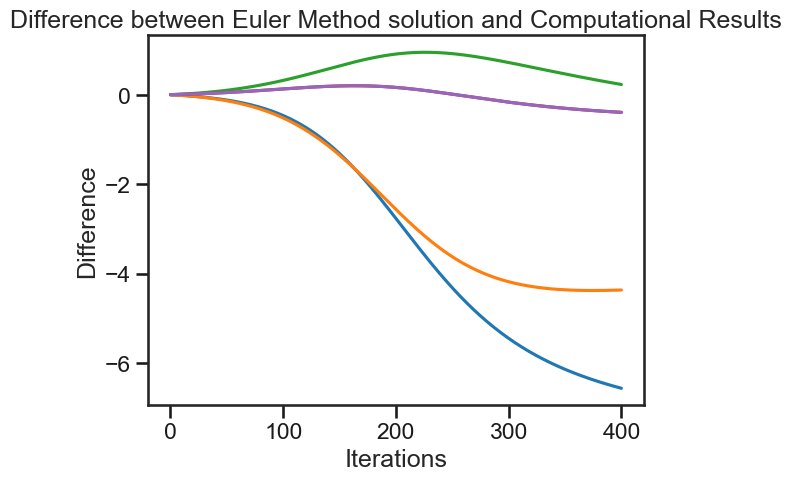

In [86]:
diff

plt.title("Difference between Euler Method solution and Computational Results")


y1 = [a[0][0][0] for a in diff]
y2 = [a[0][0][1] for a in diff]
y3 = [a[0][0][2] for a in diff]
y4 = [a[0][0][3] for a in diff]
y4 = [a[0][0][4] for a in diff]
y5 = [a[0][0][5] for a in diff]

plt.xlabel('Iterations')

plt.ylabel('Difference')

plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.plot(y4)
plt.plot(y5)

In [80]:
print(y5)

[Array(0., dtype=float32), Array(0.00054566, dtype=float32), Array(0.00110813, dtype=float32), Array(0.0016874, dtype=float32), Array(0.00228347, dtype=float32), Array(0.00289633, dtype=float32), Array(0.00352596, dtype=float32), Array(0.00417237, dtype=float32), Array(0.00483554, dtype=float32), Array(0.00551546, dtype=float32), Array(0.00621212, dtype=float32), Array(0.00692551, dtype=float32), Array(0.00765562, dtype=float32), Array(0.00840244, dtype=float32), Array(0.00916595, dtype=float32), Array(0.00994614, dtype=float32), Array(0.01074299, dtype=float32), Array(0.01155648, dtype=float32), Array(0.01238659, dtype=float32), Array(0.01323331, dtype=float32), Array(0.01409661, dtype=float32), Array(0.01497647, dtype=float32), Array(0.01587285, dtype=float32), Array(0.01678574, dtype=float32), Array(0.01771511, dtype=float32), Array(0.01866091, dtype=float32), Array(0.01962313, dtype=float32), Array(0.02060171, dtype=float32), Array(0.02159662, dtype=float32), Array(0.02260782, dtyp

Now - implement equation (4) from follow up paper, check if it matches

In [87]:
def QQt(init_w1, init_w2, c, X, Y, learning_rate, training_steps, tau):

    Q0 = np.vstack([init_w1.T, init_w2])

    QQt0 = Q0 @ Q0.T
    
    sigma_xy = Y.T @ X
    # print(sigma_xy)

    F = np.vstack([
        np.hstack([c / 2 * np.eye(sigma_xy.shape[1]), sigma_xy.T]),
        np.hstack([sigma_xy, c / 2 * np.eye(sigma_xy.shape[0])])
    ]) 

    qqts = [QQt0]
    for i in range(1, training_steps):
        t = i * learning_rate
        e_ft = np.linalg.expm(t / tau * F)

        out = e_ft @ Q0
        centre_centre = e_ft @ np.linalg.inv(F) @ e_ft - np.linalg.inv(F)
        centre = np.linalg.inv(np.eye(F.shape[0]) + 1/2 * Q0.T @ centre_centre @ Q0)
        qqt = out @ centre @ out.T 

        qqts.append(qqt)
    
    return qqts



        


In [ ]:
def check_analytical_solution(solution):
    """
    Checks analytical solution from paper against computational result.
    Input: number of equation on the paper

    3: 1/tau (FQQt + QQtF - (QQt)^2)

    4: exponent stuff, doesnt converge well
    """

    if solution == '3':
        

    elif solution == '4':

    elif solution == '10':
    
    elif solution == '12':

    elif solution == '13':

    elif solution == '14':
